<a href="https://colab.research.google.com/github/poojagpta/releases/blob/master/m5_forecasting_project/walmart_dl_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
pd.pandas.set_option("display.max_columns",None)
sns.set()
import tensorflow as tf
from tensorflow import keras
RANDOM_SEED=42
#np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from tqdm.notebook import tqdm

In [158]:
cal_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/calendar.csv")
df= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/sales_train_validation.csv")
price_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/sell_prices.csv")

#Using top down approach

In [52]:
model_df = pd.DataFrame(np.array([[c for c in df.columns if c.find("d_") == 0] ,\
                                    df[[c for c in df.columns if c.find("d_") == 0]].sum()]).transpose(),\
                           columns=['d','unit_sale'] ,index=[c for c in df.columns if c.find("d_") == 0])

model_df['unit_sale']=model_df['unit_sale'].astype(float)

In [53]:
model_df=model_df.merge(cal_df, on='d', how="inner")

In [54]:
model_df

,d,unit_sale,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,32631.0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,31749.0,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,23783.0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,25412.0,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,19146.0,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,35343.0,2016-04-20,11612,Wednesday,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,d_1910,35033.0,2016-04-21,11612,Thursday,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,d_1911,40517.0,2016-04-22,11612,Friday,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,d_1912,48962.0,2016-04-23,11613,Saturday,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


#Split Training and Validation

In [7]:
train = model_df[['unit_sale']].iloc[0:model_df.shape[0] - 28]
test = model_df[['unit_sale']].iloc[model_df.shape[0] - 28:model_df.shape[0]]

#Data Transformation

In [8]:
from sklearn.preprocessing import RobustScaler

total_sales_transformer = RobustScaler()
total_sales_transformer = total_sales_transformer.fit(train[['unit_sale']])

train['unit_sale'] = total_sales_transformer.transform(train[['unit_sale']])
test['unit_sale'] = total_sales_transformer.transform(test[['unit_sale']])

In [9]:
train

,unit_sale
0,-0.111805
1,-0.210122
2,-1.098094
3,-0.916509
4,-1.614982
...,...
1880,0.128414
1881,0.041133
1882,1.335080
1883,2.254933


In [10]:
def create_dataset(X,y, time_steps=1):
    Xs,ys =[],[]
    for i in range(len(X) - time_steps):
        v=X.iloc[i:(i+time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs),np.array(ys) 

In [11]:
TIME_STAMP=6
X_train, y_train = create_dataset(train, train[['unit_sale']], time_steps=TIME_STAMP)
X_test, y_test = create_dataset(test, test[['unit_sale']], time_steps=TIME_STAMP)

In [12]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
      keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]))
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

In [13]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
print(X_train.shape, y_train.shape)

(1879, 6, 1) (1879, 1)


In [15]:
print(X_test.shape, y_test.shape)

(22, 6, 1) (22, 1)


In [14]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
53/53 [==============================] - 8s 41ms/step - loss: 0.5156 - val_loss: 0.6786
Epoch 2/20
53/53 [==============================] - 1s 20ms/step - loss: 0.4773 - val_loss: 0.6198
Epoch 3/20
53/53 [==============================] - 1s 20ms/step - loss: 0.3674 - val_loss: 0.4685
Epoch 4/20
53/53 [==============================] - 1s 19ms/step - loss: 0.2683 - val_loss: 0.3614
Epoch 5/20
53/53 [==============================] - 1s 18ms/step - loss: 0.1983 - val_loss: 0.3317
Epoch 6/20
53/53 [==============================] - 1s 18ms/step - loss: 0.1635 - val_loss: 0.3218
Epoch 7/20
53/53 [==============================] - 1s 19ms/step - loss: 0.1579 - val_loss: 0.3166
Epoch 8/20
53/53 [==============================] - 1s 18ms/step - loss: 0.1574 - val_loss: 0.3162
Epoch 9/20
53/53 [==============================] - 1s 18ms/step - loss: 0.1544 - val_loss: 0.3156
Epoch 10/20
53/53 [==============================] - 1s 19ms/step - loss: 0.1504 - val_loss: 0.3146
Epoch 11/

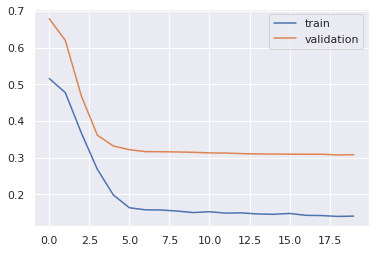

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()

In [15]:
y_pred = model.predict(X_test)

In [16]:
y_train_inv = total_sales_transformer.inverse_transform(y_train)
y_test_inv = total_sales_transformer.inverse_transform(y_test)
y_pred_inv = total_sales_transformer.inverse_transform(y_pred)

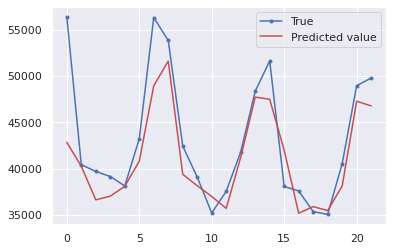

In [17]:
plt.plot(y_test_inv, marker='.', label='True')

plt.plot(y_pred_inv, 'r', label='Predicted value')

plt.legend()

**Validation Metrics**

In [159]:
h = 28
n = 1885
def rmsse(ground_truth, forecast, train_series, axis=1):
    # assuming input are numpy array or matrices
    assert axis == 0 or axis == 1
    assert type(ground_truth) == np.ndarray and type(forecast) == np.ndarray and type(train_series) == np.ndarray
    
    if axis == 1:
        # using axis == 1 we must guarantee these are matrices and not arrays
        assert ground_truth.shape[1] > 1 and forecast.shape[1] > 1 and train_series.shape[1] > 1
    
    numerator = ((ground_truth - forecast)**2).sum(axis=axis)
    if axis == 1:
        denominator = 1/(n-1) * ((train_series[:, 1:] - train_series[:, :-1]) ** 2).sum(axis=axis)
    else:
        denominator = 1/(n-1) * ((train_series[1:] - train_series[:-1]) ** 2).sum(axis=axis)
    return (1/h * numerator/denominator) ** 0.5

**Validating the results**

In [160]:
agg_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/top_down_agg_levels.csv',sep=',')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/m5-forecasting-accuracy/dataset.csv',sep=',')

In [161]:
agg_df.drop('Unnamed: 0',axis=1,inplace=True)
df.drop('Unnamed: 0',axis=1,inplace=True)

In [162]:
id_cols = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
level_groupings = {2:["state_id"], 3:["store_id"], 4:["cat_id"], 5:["dept_id"],
                  6:["state_id","cat_id"],7:["state_id","dept_id"],
                  8:["store_id","cat_id"], 9:["store_id","dept_id"],
                  10:["item_id"], 11:["item_id","state_id"]}

In [163]:
#Metrics for level = 1
this_level_df1 = agg_df[agg_df["level"]==1].copy()
for d in range(1, 22):
  this_level_df1["F_" + str(1) + "_" + str(1885 + d)] = y_pred_inv[d-1]

for d in range(22,29):
  this_level_df1["F_" + str(1) + "_" + str(1885 + d)] = y_pred_inv[21]


In [168]:
this_level_df1[[c for c in  this_level_df1.columns if c.find('F_')==0]]

,F_1_1886,F_1_1887,F_1_1888,F_1_1889,F_1_1890,F_1_1891,F_1_1892,F_1_1893,F_1_1894,F_1_1895,F_1_1896,F_1_1897,F_1_1898,F_1_1899,F_1_1900,F_1_1901,F_1_1902,F_1_1903,F_1_1904,F_1_1905,F_1_1906,F_1_1907,F_1_1908,F_1_1909,F_1_1910,F_1_1911,F_1_1912,F_1_1913
0,42833.175781,40250.238281,36608.617188,37006.167969,38078.199219,40794.234375,48954.042969,51622.523438,39370.726562,38138.191406,36974.878906,35683.582031,41213.691406,47724.945312,47495.429688,41964.378906,35157.398438,35881.855469,35448.054688,38099.664062,47278.292969,46782.097656,46782.097656,46782.097656,46782.097656,46782.097656,46782.097656,46782.097656


In [169]:
df["last28_mean"] = df[[c for c in df.columns if c.find("d_")==0 and\
        int(c.split("_")[1]) in range(1858, 1886)] +\
       ["id"]].set_index("id").transpose().mean().reset_index()[0]

In [172]:
for l in tqdm(range(1, 10)):

    if(l >=2):
      this_level_df = agg_df[agg_df["level"]==l].copy()
      for d in range(1, 29):
        this_level_df["F_" + str(l) + "_" + str(1885 + d)] = (this_level_df["d_" + str(1885 + d - 28)]/this_level_df["d_" + str(1885 + d - 28)].sum()) * this_level_df1['F_1_'+ str(1885 + d)][0]
    else:
       this_level_df = this_level_df1

    # from this level, distribute forecast to all level 12 series
    # find columns with non 'all' entries
    important_column_ids = list(this_level_df[id_cols].columns[this_level_df[id_cols].nunique()!=1])
    this_level_df.reset_index(drop=True, inplace=True)
    for i, row in this_level_df.iterrows():
        #eg. level =1
        if len(important_column_ids) == 0:
            level_mean_with_cond = this_level_df[[c for c in df.columns if c.find("d_")==0 and\
                                   int(c.split("_")[1]) in range(1858, 1886)]].transpose().mean()[0]
            proportion = df["last28_mean"] / level_mean_with_cond 
            for d in range(1, 29):
                df["F_" + str(l) + "_" + str(1885 + d)] = list(this_level_df["F_" + str(l) + "_" + str(1885 + d)])[0] * proportion
        else:
           #eg. Level 2 and above
            cond = True
            for col in important_column_ids:
                cond = cond & (df[col] == row[col])
                
            level_mean_with_cond = this_level_df[[c for c in df.columns if c.find("d_")==0 and\
                                   int(c.split("_")[1]) in range(1858, 1886)]].transpose().mean()[i]
            proportion = df["last28_mean"] / level_mean_with_cond 
            for d in range(1, 29):
                df.loc[cond, "F_" + str(l) + "_" + str(1885 + d)] = row["F_" + str(l) + "_" + str(1885 + d)] * proportion
    


  0%|          | 0/9 [00:00<?, ?it/s]

In [173]:
df[[c for c in df.columns if  c.find("F_") == 0]]

,F_2_1886,F_2_1887,F_2_1888,F_2_1889,F_2_1890,F_2_1891,F_2_1892,F_2_1893,F_2_1894,F_2_1895,F_2_1896,F_2_1897,F_2_1898,F_2_1899,F_2_1900,F_2_1901,F_2_1902,F_2_1903,F_2_1904,F_2_1905,F_2_1906,F_2_1907,F_2_1908,F_2_1909,F_2_1910,F_2_1911,F_2_1912,F_2_1913,F_3_1886,F_3_1887,F_3_1888,F_3_1889,F_3_1890,F_3_1891,F_3_1892,F_3_1893,F_3_1894,F_3_1895,F_3_1896,F_3_1897,F_3_1898,F_3_1899,F_3_1900,F_3_1901,F_3_1902,F_3_1903,F_3_1904,F_3_1905,F_3_1906,F_3_1907,F_3_1908,F_3_1909,F_3_1910,F_3_1911,F_3_1912,F_3_1913,F_4_1886,F_4_1887,F_4_1888,F_4_1889,F_4_1890,F_4_1891,F_4_1892,F_4_1893,F_4_1894,F_4_1895,F_4_1896,F_4_1897,F_4_1898,F_4_1899,F_4_1900,F_4_1901,F_4_1902,F_4_1903,F_4_1904,F_4_1905,F_4_1906,F_4_1907,F_4_1908,F_4_1909,F_4_1910,F_4_1911,F_4_1912,F_4_1913,F_5_1886,F_5_1887,F_5_1888,F_5_1889,F_5_1890,F_5_1891,F_5_1892,F_5_1893,F_5_1894,F_5_1895,F_5_1896,F_5_1897,F_5_1898,F_5_1899,F_5_1900,F_5_1901,F_5_1902,F_5_1903,F_5_1904,F_5_1905,F_5_1906,F_5_1907,F_5_1908,F_5_1909,F_5_1910,F_5_1911,F_5_1912,F_5_1913,F_6_1886,F_6_1887,F_6_1888,F_6_1889,F_6_1890,F_6_1891,F_6_1892,F_6_1893,F_6_1894,F_6_1895,F_6_1896,F_6_1897,F_6_1898,F_6_1899,F_6_1900,F_6_1901,F_6_1902,F_6_1903,F_6_1904,F_6_1905,F_6_1906,F_6_1907,F_6_1908,F_6_1909,F_6_1910,F_6_1911,F_6_1912,F_6_1913,F_7_1886,F_7_1887,F_7_1888,F_7_1889,F_7_1890,F_7_1891,F_7_1892,F_7_1893,F_7_1894,F_7_1895,F_7_1896,F_7_1897,F_7_1898,F_7_1899,F_7_1900,F_7_1901,F_7_1902,F_7_1903,F_7_1904,F_7_1905,F_7_1906,F_7_1907,F_7_1908,F_7_1909,F_7_1910,F_7_1911,F_7_1912,F_7_1913,F_8_1886,F_8_1887,F_8_1888,F_8_1889,F_8_1890,F_8_1891,F_8_1892,F_8_1893,F_8_1894,F_8_1895,F_8_1896,F_8_1897,F_8_1898,F_8_1899,F_8_1900,F_8_1901,F_8_1902,F_8_1903,F_8_1904,F_8_1905,F_8_1906,F_8_1907,F_8_1908,F_8_1909,F_8_1910,F_8_1911,F_8_1912,F_8_1913,F_9_1886,F_9_1887,F_9_1888,F_9_1889,F_9_1890,F_9_1891,F_9_1892,F_9_1893,F_9_1894,F_9_1895,F_9_1896,F_9_1897,F_9_1898,F_9_1899,F_9_1900,F_9_1901,F_9_1902,F_9_1903,F_9_1904,F_9_1905,F_9_1906,F_9_1907,F_9_1908,F_9_1909,F_9_1910,F_9_1911,F_9_1912,F_9_1913,F_1_1886,F_1_1887,F_1_1888,F_1_1889,F_1_1890,F_1_1891,F_1_1892,F_1_1893,F_1_1894,F_1_1895,F_1_1896,F_1_1897,F_1_1898,F_1_1899,F_1_1900,F_1_1901,F_1_1902,F_1_1903,F_1_1904,F_1_1905,F_1_1906,F_1_1907,F_1_1908,F_1_1909,F_1_1910,F_1_1911,F_1_1912,F_1_1913
0,1.056802,1.016782,0.831022,0.789654,0.882615,0.972397,1.222200,1.235964,0.950519,0.906605,0.866509,0.804409,0.996976,1.153067,1.078746,0.891641,0.805386,0.824012,0.843683,0.883064,1.087304,1.173025,1.163657,1.153194,1.186528,1.085888,1.170042,1.217046,0.975852,0.943280,0.798886,0.752100,0.901173,0.981334,1.306192,1.249900,0.916870,0.845434,0.837476,0.789996,1.037072,1.129996,1.058398,0.808436,0.770176,0.762787,0.856391,1.043738,1.369564,1.187511,1.113226,1.133472,1.221088,1.124488,1.192013,1.053305,1.047999,1.022926,0.959361,0.910670,0.947720,0.955381,1.103330,1.128913,0.893686,0.871883,0.967155,0.768842,0.994040,1.037436,1.073042,0.982073,0.919203,0.871766,0.896485,1.032515,1.046734,1.106109,1.094474,1.216393,1.218948,1.146751,1.027538,0.971659,1.047271,1.027733,0.940320,0.911457,0.966688,0.968821,1.113871,1.144145,0.905548,0.865077,0.979593,0.771079,0.999201,1.039117,1.072567,0.967603,0.914778,0.852843,0.898764,1.042986,1.038629,1.093169,1.074582,1.191740,1.209937,1.140546,1.024429,0.987677,0.972888,1.046008,0.971043,0.878536,0.979866,0.972372,1.189248,1.169678,0.941536,0.889460,0.970433,0.749008,1.050718,1.038024,1.064231,0.951729,0.958862,0.857915,0.959049,0.924492,0.972996,1.165135,1.116017,1.215555,1.232337,1.030133,0.961478,0.997594,0.965642,1.079705,0.965577,0.885361,0.989064,0.982134,1.206194,1.169831,0.946897,0.886983,0.992099,0.751650,1.045918,1.021545,1.058627,0.933071,0.963996,0.850619,0.960714,0.928046,0.965946,1.153223,1.096792,1.198013,1.231293,1.028880,0.947750,1.005696,0.942316,1.238919,0.921622,0.770529,0.845461,0.920043,1.399211,1.184309,0.940112,0.946124,1.080881,0.628973,1.150208,1.097050,1.031309,0.892641,0.897540,0.679809,1.035453,0.999669,0.964941,1.318960,1.148834,1.208866,1

In [174]:
# remake agg_df
new_agg_df = pd.DataFrame(df[[c for c in df.columns if c.find("d_") == 0 or c.find("F_") == 0]].sum()).transpose()
id_cols = ["item_id", "dept_id", "cat_id", "store_id", "state_id"]
for col in id_cols:
    new_agg_df[col] = 'all'
new_agg_df["level"] = 1
new_agg_df["weight"] = 1/12
column_order = new_agg_df.columns

for level in level_groupings:
    temp_df = df.groupby(by=level_groupings[level]).sum().reset_index()
    temp_df["level"] = level
    for c in column_order:
        if c not in temp_df.columns:
            temp_df[c] = 'all'
    new_agg_df = new_agg_df.append(temp_df[column_order])
del temp_df

In [175]:
train_series_cols = [c for c in df.columns if c.find("d_") == 0][:-28]
ground_truth_cols = [c for c in df.columns if c.find("d_") == 0][-28:]

forecast_cols_dict = {}
for i in range(1, 10):
    forecast_cols_dict[i] = [c for c in df.columns if c.find("F_"+str(i)+"_") == 0]

In [176]:
for i in range(1, 10):
    df["rmsse_" + str(i)+'_tp'] = rmsse(np.array(df[ground_truth_cols]), 
        np.array(df[forecast_cols_dict[i]]), np.array(df[train_series_cols]))
    new_agg_df["rmsse_" + str(i)+'_tp'] = rmsse(np.array(new_agg_df[ground_truth_cols]), 
        np.array(new_agg_df[forecast_cols_dict[i]]), np.array(new_agg_df[train_series_cols]))

In [177]:
for i in range(1, 10):
    df["wrmsse_" + str(i)+'_tp'] = df["weight"] * df["rmsse_" + str(i)+'_tp']
    new_agg_df["wrmsse_" + str(i)+'_tp'] = new_agg_df["weight"] * new_agg_df["rmsse_" + str(i)+'_tp']

In [186]:
for i in range(1, 10):
    print("Aggregation by level", str(i) + ":")
    print(df["wrmsse_" + str(i)+'_tp'].sum() - 0.5)
    print()

Aggregation by level 1:
0.5462489481196959

Aggregation by level 2:
0.5480778788328067

Aggregation by level 3:
0.5508635551352348

Aggregation by level 4:
0.5468421154690446

Aggregation by level 5:
0.5453324185887358

Aggregation by level 6:
0.5488675334792226

Aggregation by level 7:
0.5473753996042894

Aggregation by level 8:
0.5534896258530848

Aggregation by level 9:
0.553596678669773

